
# CTC forced alignment API tutorial

**Author**: [Xiaohui Zhang](xiaohuizhang@meta.com)_, [Moto Hira](moto@meta.com)_

The forced alignment is a process to align transcript with speech.
This tutorial shows how to align transcripts to speech using
:py:func:`torchaudio.functional.forced_align` which was developed along the work of
[Scaling Speech Technology to 1,000+ Languages](https://research.facebook.com/publications/scaling-speech-technology-to-1000-languages/)_.

:py:func:`~torchaudio.functional.forced_align` has custom CPU and CUDA
implementations which are more performant than the vanilla Python
implementation above, and are more accurate.
It can also handle missing transcript with special ``<star>`` token.

There is also a high-level API, :py:class:`torchaudio.pipelines.Wav2Vec2FABundle`,
which wraps the pre/post-processing explained in this tutorial and makes it easy
to run forced-alignments.
[Forced alignment for multilingual data](./forced_alignment_for_multilingual_data_tutorial.html)_ uses this API to
illustrate how to align non-English transcripts.


## Preparation



In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu118
2.1.0+cu118


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
import IPython
import matplotlib.pyplot as plt

import torchaudio.functional as F

First we prepare the speech data and the transcript we area going
to use.




In [4]:
SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
waveform, _ = torchaudio.load(SPEECH_FILE)
TRANSCRIPT = "i had that curiosity beside me at this moment".split()

100%|██████████| 106k/106k [00:00<00:00, 11.9MB/s]


### Generating emissions

:py:func:`~torchaudio.functional.forced_align` takes emission and
token sequences and outputs timestaps of the tokens and their scores.

Emission reperesents the frame-wise probability distribution over
tokens, and it can be obtained by passing waveform to an acoustic
model.

Tokens are numerical expression of transcripts. There are many ways to
tokenize transcripts, but here, we simply map alphabets into integer,
which is how labels were constructed when the acoustice model we are
going to use was trained.

We will use a pre-trained Wav2Vec2 model,
:py:data:`torchaudio.pipelines.MMS_FA`, to obtain emission and tokenize
the transcript.




In [5]:
bundle = torchaudio.pipelines.MMS_FA

model = bundle.get_model(with_star=False).to(device)
with torch.inference_mode():
    emission, _ = model(waveform.to(device))

Downloading: "https://dl.fbaipublicfiles.com/mms/torchaudio/ctc_alignment_mling_uroman/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 1.18G/1.18G [00:10<00:00, 124MB/s]


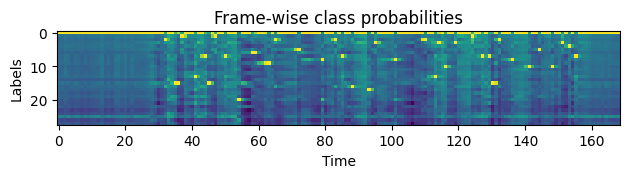

In [6]:
def plot_emission(emission):
    fig, ax = plt.subplots()
    ax.imshow(emission.cpu().T)
    ax.set_title("Frame-wise class probabilities")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.tight_layout()


plot_emission(emission[0])

### Tokenize the transcript

We create a dictionary, which maps each label into token.



In [7]:
LABELS = bundle.get_labels(star=None)
DICTIONARY = bundle.get_dict(star=None)
for k, v in DICTIONARY.items():
    print(f"{k}: {v}")

-: 0
a: 1
i: 2
e: 3
n: 4
o: 5
u: 6
t: 7
s: 8
r: 9
m: 10
k: 11
l: 12
d: 13
g: 14
h: 15
y: 16
b: 17
p: 18
w: 19
c: 20
v: 21
j: 22
z: 23
f: 24
': 25
q: 26
x: 27


converting transcript to tokens is as simple as



In [8]:
tokenized_transcript = [DICTIONARY[c] for word in TRANSCRIPT for c in word]

for t in tokenized_transcript:
    print(t, end=" ")
print()

2 15 1 13 7 15 1 7 20 6 9 2 5 8 2 7 16 17 3 8 2 13 3 10 3 1 7 7 15 2 8 10 5 10 3 4 7 


## Computing alignments

### Frame-level alignments

Now we call TorchAudio’s forced alignment API to compute the
frame-level alignment. For the detail of function signature, please
refer to :py:func:`~torchaudio.functional.forced_align`.




In [9]:
def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]  # remove batch dimension for simplicity
    scores = scores.exp()  # convert back to probability
    return alignments, scores


aligned_tokens, alignment_scores = align(emission, tokenized_transcript)

Now let's look at the output.



In [10]:
for i, (ali, score) in enumerate(zip(aligned_tokens, alignment_scores)):
    print(f"{i:3d}:\t{ali:2d} [{LABELS[ali]}], {score:.2f}")

  0:	 0 [-], 1.00
  1:	 0 [-], 1.00
  2:	 0 [-], 1.00
  3:	 0 [-], 1.00
  4:	 0 [-], 1.00
  5:	 0 [-], 1.00
  6:	 0 [-], 1.00
  7:	 0 [-], 1.00
  8:	 0 [-], 1.00
  9:	 0 [-], 1.00
 10:	 0 [-], 1.00
 11:	 0 [-], 1.00
 12:	 0 [-], 1.00
 13:	 0 [-], 1.00
 14:	 0 [-], 1.00
 15:	 0 [-], 1.00
 16:	 0 [-], 1.00
 17:	 0 [-], 1.00
 18:	 0 [-], 1.00
 19:	 0 [-], 1.00
 20:	 0 [-], 1.00
 21:	 0 [-], 1.00
 22:	 0 [-], 1.00
 23:	 0 [-], 1.00
 24:	 0 [-], 1.00
 25:	 0 [-], 1.00
 26:	 0 [-], 1.00
 27:	 0 [-], 1.00
 28:	 0 [-], 1.00
 29:	 0 [-], 1.00
 30:	 0 [-], 1.00
 31:	 0 [-], 1.00
 32:	 2 [i], 1.00
 33:	 0 [-], 1.00
 34:	 0 [-], 1.00
 35:	15 [h], 1.00
 36:	15 [h], 0.93
 37:	 1 [a], 1.00
 38:	 0 [-], 0.96
 39:	 0 [-], 1.00
 40:	 0 [-], 1.00
 41:	13 [d], 1.00
 42:	 0 [-], 1.00
 43:	 0 [-], 0.97
 44:	 7 [t], 1.00
 45:	15 [h], 1.00
 46:	 0 [-], 0.98
 47:	 1 [a], 1.00
 48:	 0 [-], 1.00
 49:	 0 [-], 1.00
 50:	 7 [t], 1.00
 51:	 0 [-], 1.00
 52:	 0 [-], 1.00
 53:	 0 [-], 1.00
 54:	20 [c], 1.00
 55:	 0 [-

<div class="alert alert-info"><h4>Note</h4><p>The alignment is expressed in the frame cordinate of the emission,
   which is different from the original waveform.</p></div>

It contains blank tokens and repeated tokens. The following is the
interpretation of the non-blank tokens.

```
31:     0 [-], 1.00
32:     2 [i], 1.00  "i" starts and ends
33:     0 [-], 1.00
34:     0 [-], 1.00
35:    15 [h], 1.00  "h" starts
36:    15 [h], 0.93  "h" ends
37:     1 [a], 1.00  "a" starts and ends
38:     0 [-], 0.96
39:     0 [-], 1.00
40:     0 [-], 1.00
41:    13 [d], 1.00  "d" starts and ends
42:     0 [-], 1.00
```
<div class="alert alert-info"><h4>Note</h4><p>When same token occured after blank tokens, it is not treated as
   a repeat, but as a new occurrence.

```
a a a b -> a b
a - - b -> a b
a a - b -> a b
a - a b -> a a b
  ^^^       ^^^</p></div>
```


### Token-level alignments

Next step is to resolve the repetation, so that each alignment does
not depend on previous alignments.
:py:func:`torchaudio.functional.merge_tokens` computes the
:py:class:`~torchaudio.functional.TokenSpan` object, which represents
which token from the transcript is present at what time span.



In [11]:
token_spans = F.merge_tokens(aligned_tokens, alignment_scores)

print("Token\tTime\tScore")
for s in token_spans:
    print(f"{LABELS[s.token]}\t[{s.start:3d}, {s.end:3d})\t{s.score:.2f}")

Token	Time	Score
i	[ 32,  33)	1.00
h	[ 35,  37)	0.96
a	[ 37,  38)	1.00
d	[ 41,  42)	1.00
t	[ 44,  45)	1.00
h	[ 45,  46)	1.00
a	[ 47,  48)	1.00
t	[ 50,  51)	1.00
c	[ 54,  55)	1.00
u	[ 58,  60)	0.98
r	[ 63,  64)	1.00
i	[ 65,  66)	1.00
o	[ 72,  73)	1.00
s	[ 79,  80)	1.00
i	[ 83,  84)	1.00
t	[ 85,  86)	1.00
y	[ 88,  89)	1.00
b	[ 93,  94)	1.00
e	[ 95,  96)	1.00
s	[101, 102)	1.00
i	[110, 111)	1.00
d	[113, 114)	1.00
e	[114, 115)	0.85
m	[116, 117)	1.00
e	[119, 120)	1.00
a	[124, 125)	1.00
t	[127, 128)	1.00
t	[129, 130)	1.00
h	[130, 131)	1.00
i	[132, 133)	1.00
s	[136, 137)	1.00
m	[141, 142)	1.00
o	[144, 145)	1.00
m	[148, 149)	1.00
e	[151, 152)	1.00
n	[153, 154)	1.00
t	[155, 156)	1.00


### Word-level alignments

Now let’s group the token-level alignments into word-level alignments.



In [12]:
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret


word_spans = unflatten(token_spans, [len(word) for word in TRANSCRIPT])

### Audio previews




In [13]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


num_frames = emission.size(1)

In [14]:
# Generate the audio for each segment
print(TRANSCRIPT)
IPython.display.Audio(SPEECH_FILE)

['i', 'had', 'that', 'curiosity', 'beside', 'me', 'at', 'this', 'moment']


In [15]:
preview_word(waveform, word_spans[0], num_frames, TRANSCRIPT[0])

i (1.00): 0.644 - 0.664 sec


In [16]:
preview_word(waveform, word_spans[1], num_frames, TRANSCRIPT[1])

had (0.98): 0.704 - 0.845 sec


In [17]:
preview_word(waveform, word_spans[2], num_frames, TRANSCRIPT[2])

that (1.00): 0.885 - 1.026 sec


In [18]:
preview_word(waveform, word_spans[3], num_frames, TRANSCRIPT[3])

curiosity (1.00): 1.086 - 1.790 sec


In [19]:
preview_word(waveform, word_spans[4], num_frames, TRANSCRIPT[4])

beside (0.97): 1.871 - 2.314 sec


In [20]:
preview_word(waveform, word_spans[5], num_frames, TRANSCRIPT[5])

me (1.00): 2.334 - 2.414 sec


In [21]:
preview_word(waveform, word_spans[6], num_frames, TRANSCRIPT[6])

at (1.00): 2.495 - 2.575 sec


In [22]:
preview_word(waveform, word_spans[7], num_frames, TRANSCRIPT[7])

this (1.00): 2.595 - 2.756 sec


In [23]:
preview_word(waveform, word_spans[8], num_frames, TRANSCRIPT[8])

moment (1.00): 2.837 - 3.138 sec


### Visualization

Now let's look at the alignment result and segment the original
speech into words.



In [24]:
def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start + 0.1, t_spans[-1].end - 0.1
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    axes[1].set_xlim([0, None])
    fig.tight_layout()

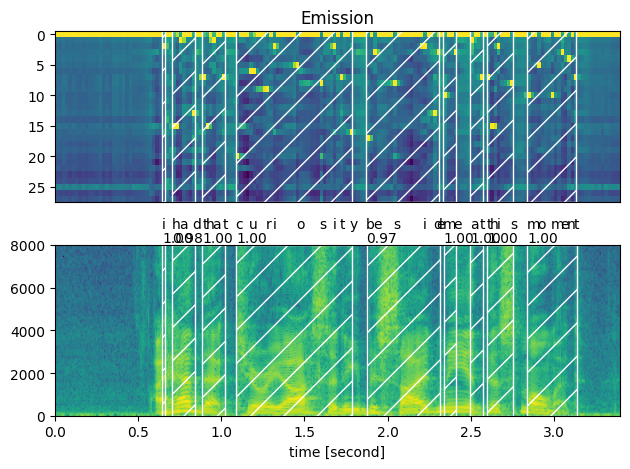

In [25]:
plot_alignments(waveform, word_spans, emission, TRANSCRIPT)

### Inconsistent treatment of ``blank`` token

When splitting the token-level alignments into words, you will
notice that some blank tokens are treated differently, and this makes
the interpretation of the result somehwat ambigious.

This is easy to see when we plot the scores. The following figure
shows word regions and non-word regions, with the frame-level scores
of non-blank tokens.



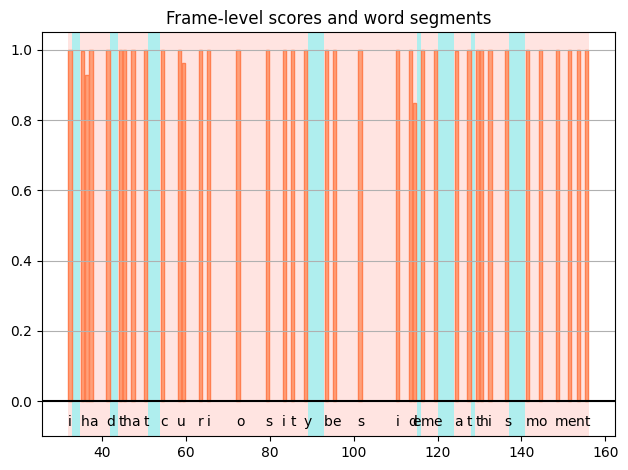

In [26]:
def plot_scores(word_spans, scores):
    fig, ax = plt.subplots()
    span_xs, span_hs = [], []
    ax.axvspan(word_spans[0][0].start - 0.05, word_spans[-1][-1].end + 0.05, facecolor="paleturquoise", edgecolor="none", zorder=-1)
    for t_span in word_spans:
        for span in t_span:
            for t in range(span.start, span.end):
                span_xs.append(t + 0.5)
                span_hs.append(scores[t].item())
            ax.annotate(LABELS[span.token], (span.start, -0.07))
        ax.axvspan(t_span[0].start - 0.05, t_span[-1].end + 0.05, facecolor="mistyrose", edgecolor="none", zorder=-1)
    ax.bar(span_xs, span_hs, color="lightsalmon", edgecolor="coral")
    ax.set_title("Frame-level scores and word segments")
    ax.set_ylim(-0.1, None)
    ax.grid(True, axis="y")
    ax.axhline(0, color="black")
    fig.tight_layout()


plot_scores(word_spans, alignment_scores)

In this plot, the blank tokens are those highlighted area without
vertical bar.
You can see that there are blank tokens which are interpreted as
part of a word (highlighted red), while the others (highlighted blue)
are not.

One reason for this is because the model was trained without a
label for the word boundary. The blank tokens are treated not just
as repeatation but also as silence between words.

But then, a question arises. Should frames immediately after or
near the end of a word be silent or repeat?

In the above example, if you go back to the previous plot of
spectrogram and word regions, you see that after "y" in "curiosity",
there is still some activities in multiple frequency buckets.

Would it be more accurate if that frame was included in the word?

Unfortunately, CTC does not provide a comprehensive solution to this.
Models trained with CTC are known to exhibit "peaky" response,
that is, they tend to spike for an aoccurance of a label, but the
spike does not last for the duration of the label.
(Note: Pre-trained Wav2Vec2 models tend to spike at the beginning of
label occurances, but this not always the case.)

:cite:`zeyer2021does` has in-depth alanysis on the peaky behavior of
CTC.
We encourage those who are interested understanding more to refer
to the paper.
The following is a quote from the paper, which is the exact issue we
are facing here.

   *Peaky behavior can be problematic in certain cases,*
   *e.g. when an application requires to not use the blank label,*
   *e.g. to get meaningful time accurate alignments of phonemes*
   *to a transcription.*



## Advanced: Handling transcripts with ``<star>`` token

Now let’s look at when the transcript is partially missing, how can we
improve alignment quality using the ``<star>`` token, which is capable of modeling
any token.

Here we use the same English example as used above. But we remove the
beginning text ``“i had that curiosity beside me at”`` from the transcript.
Aligning audio with such transcript results in wrong alignments of the
existing word “this”. However, this issue can be mitigated by using the
``<star>`` token to model the missing text.




First, we extend the dictionary to include the ``<star>`` token.



In [27]:
DICTIONARY["*"] = len(DICTIONARY)

Next, we extend the emission tensor with the extra dimension
corresponding to the ``<star>`` token.




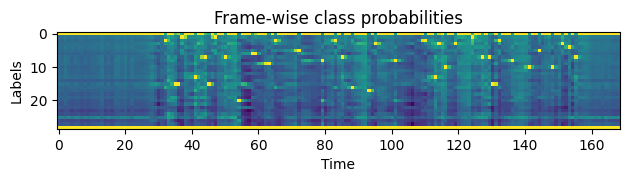

In [28]:
star_dim = torch.zeros((1, emission.size(1), 1), device=emission.device, dtype=emission.dtype)
emission = torch.cat((emission, star_dim), 2)

assert len(DICTIONARY) == emission.shape[2]

plot_emission(emission[0])

The following function combines all the processes, and compute
word segments from emission in one-go.



In [29]:
def compute_alignments(emission, transcript, dictionary):
    tokens = [dictionary[char] for word in transcript for char in word]
    alignment, scores = align(emission, tokens)
    token_spans = F.merge_tokens(alignment, scores)
    word_spans = unflatten(token_spans, [len(word) for word in transcript])
    return word_spans

### Full Transcript



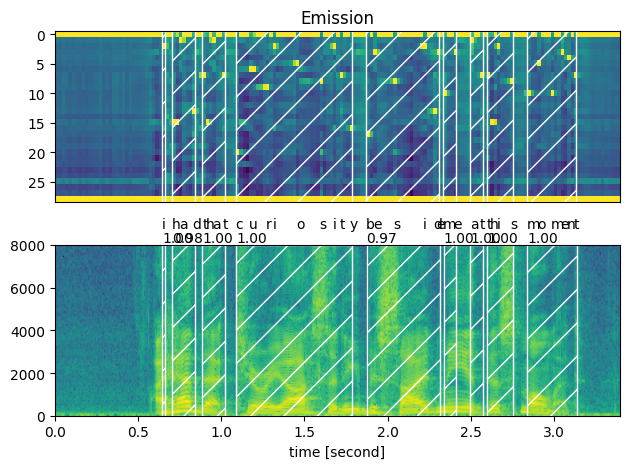

In [30]:
word_spans = compute_alignments(emission, TRANSCRIPT, DICTIONARY)
plot_alignments(waveform, word_spans, emission, TRANSCRIPT)

### Partial Transcript with ``<star>`` token

Now we replace the first part of the transcript with the ``<star>`` token.



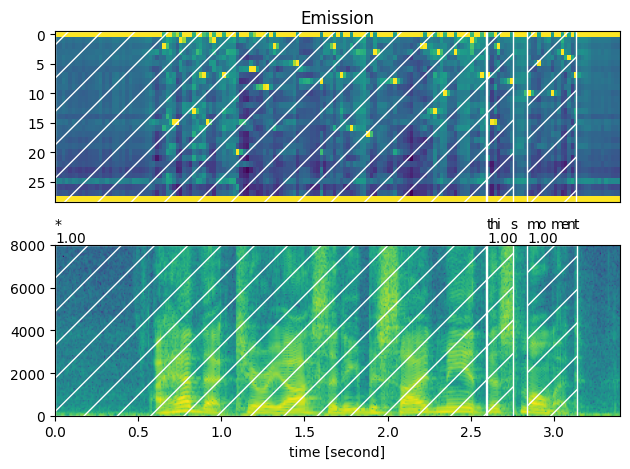

In [31]:
transcript = "* this moment".split()
word_spans = compute_alignments(emission, transcript, DICTIONARY)
plot_alignments(waveform, word_spans, emission, transcript)

In [32]:
preview_word(waveform, word_spans[0], num_frames, transcript[0])

* (1.00): 0.000 - 2.595 sec


In [33]:
preview_word(waveform, word_spans[1], num_frames, transcript[1])

this (1.00): 2.595 - 2.756 sec


In [34]:
preview_word(waveform, word_spans[2], num_frames, transcript[2])

moment (1.00): 2.837 - 3.138 sec


### Partial Transcript without ``<star>`` token

As a comparison, the following aligns the partial transcript
without using ``<star>`` token.
It demonstrates the effect of ``<star>`` token for dealing with deletion errors.



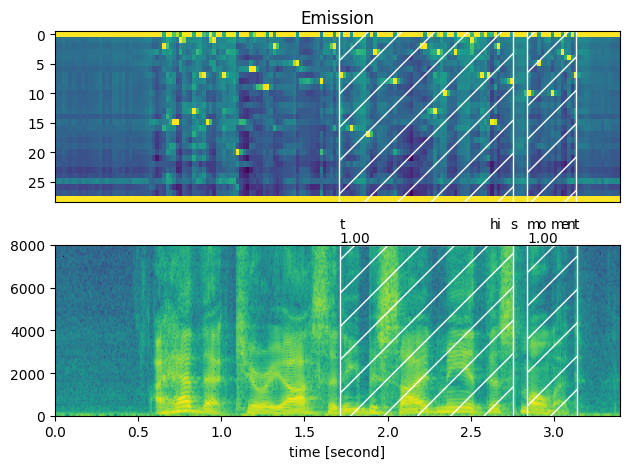

In [35]:
transcript = "this moment".split()
word_spans = compute_alignments(emission, transcript, DICTIONARY)
plot_alignments(waveform, word_spans, emission, transcript)

## Conclusion

In this tutorial, we looked at how to use torchaudio’s forced alignment
API to align and segment speech files, and demonstrated one advanced usage:
How introducing a ``<star>`` token could improve alignment accuracy when
transcription errors exist.




## Acknowledgement

Thanks to [Vineel Pratap](vineelkpratap@meta.com)_ and [Zhaoheng
Ni](zni@meta.com)_ for developing and open-sourcing the
forced aligner API.

